In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
users_path='/content/drive/MyDrive/STS DATA/users.csv'
user=pd.read_csv(users_path)

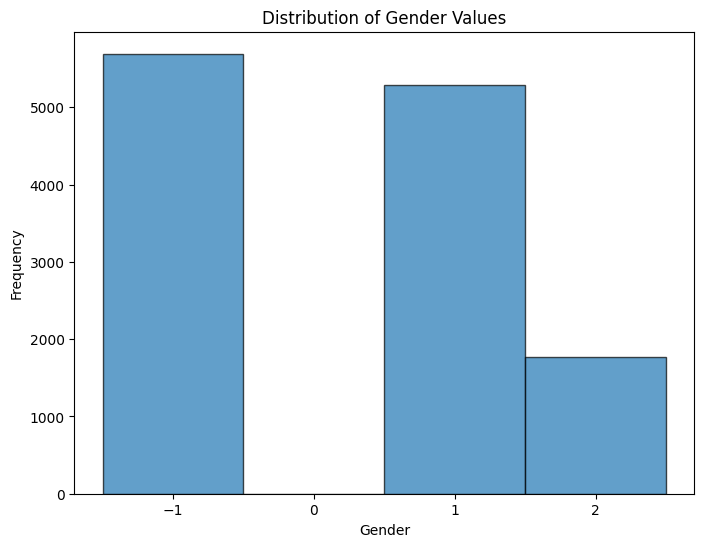

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Drop NaN values from the gender column
gender_values = user['gender'].dropna()

# Create a histogram based on the unique gender values
plt.figure(figsize=(8, 6))
plt.hist(gender_values, bins=np.arange(min(gender_values)-0.5, max(gender_values)+1.5, 1), edgecolor='black', alpha=0.7)
plt.title('Distribution of Gender Values')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(ticks=np.arange(min(gender_values), max(gender_values)+1, 1))
plt.show()


In [4]:
import pandas as pd


df_filtered = user.drop_duplicates()




In [49]:
df_filtered_user=df_filtered.iloc[:-1,:]
# Replace all occurrences of -1 with 0 in the DataFrame
df_filtered_user = df_filtered_user.replace(-1, 0)


In [50]:
df_filtered_user

,userID,age,gender
0,1.0,0.0,0.0
1,2.0,0.0,0.0
13,3.0,0.0,0.0
31,4.0,0.0,0.0
79,5.0,0.0,0.0
...,...,...,...
12731,1921.0,0.0,0.0
12732,1922.0,35.0,1.0
12748,1923.0,0.0,0.0
12749,1924.0,15.0,2.0


In [51]:
df_grouped_user = df_filtered_user.groupby('userID').agg({'age': 'mean', 'gender': 'mean'}).reset_index()

# Round down the values
df_grouped_user['age'] = df_grouped_user['age'].apply(lambda x: int(x))
df_grouped_user['gender'] = df_grouped_user['gender'].apply(lambda x: int(x))

In [53]:
np.min(df_grouped_user)

0.0

In [99]:
import pandas as pd
import numpy as np

# Extract demographic features (excluding userID)
demographic_df = df_grouped_user.iloc[:, 1:]

# Calculate the Pearson correlation coefficient matrix (x x x)
pcc_matrix = demographic_df.corr(method='pearson')

# Define the penalty threshold
penalty_threshold = demographic_df.shape[1] / 2 + 1

# Apply the improvised PCC formula to adjust similarity scores
improvised_pcc_matrix = pcc_matrix.copy()
for i in range(len(improvised_pcc_matrix)):
    for j in range(len(improvised_pcc_matrix)):
        # Calculate the intersection of users between features i and j
        intersection_users = set(demographic_df[demographic_df.iloc[:, i].notna()].index) & set(demographic_df[demographic_df.iloc[:, j].notna()].index)
        # Calculate the penalty term
        penalty = min(len(intersection_users), penalty_threshold)
        # Apply the improvised PCC formula
        if len(intersection_users) >= penalty_threshold:
            improvised_pcc_matrix.iloc[i, j] = max(0, improvised_pcc_matrix.iloc[i, j])
        else:
            improvised_pcc_matrix.iloc[i, j] = max(0, improvised_pcc_matrix.iloc[i, j]) * penalty / penalty_threshold

# Perform Singular Value Decomposition (SVD) to reduce dimensions to x x k
k = 2  # Specify the desired number of dimensions
U, Sigma, VT = np.linalg.svd(improvised_pcc_matrix)

# Take the top k singular vectors
U_k = U[:, :k]

# Clip negative values to zero
U_k = np.maximum(U_k, 0)

# Display the resulting user demographic matrix
print("User Demographic Matrix (U_k) after clipping negative values:")
print(U_k)




User Demographic Matrix (U_k) after clipping negative values:
[[0.         0.        ]
 [0.         0.70710678]]


In [100]:
user_features_df = df_grouped_user[['age', 'gender']]
user_feature_matrix = user_features_df @ U_k


user_feature_matrix['userID'] = user['userID']

user_feature_matrix = user_feature_matrix[['userID'] + list(range(k))]
user_feature_matrix = user_feature_matrix.rename(columns={0: 'Feature 1', 1: 'Feature 2'})

In [105]:
np.max(user_feature_matrix)

172.0

In [106]:
import pandas as pd
items_path='/content/drive/MyDrive/STS DATA/Item_matrix.csv'
item=pd.read_csv(items_path)

In [107]:
item=item.iloc[:,:7]
item = item.replace(-1, 0)

In [108]:
item

,itemID,category,category2,category3,crowdedness,creationDate,knowledgeOfSurroundings
0,1,1,0,0,0,-1,0
1,2,1,0,0,0,-1,0
2,2,1,0,0,0,-1,0
3,2,1,0,0,0,-1,0
4,2,1,0,0,0,-1,0
...,...,...,...,...,...,...,...
12751,53,4,0,0,0,03/04/2014 14:14:18,0
12752,46,4,0,0,0,03/04/2014 14:14:18,0
12753,43,4,0,0,0,03/04/2014 14:14:18,0
12754,56,8,0,0,0,03/04/2014 14:14:18,0


In [109]:
item['creationDate'] = pd.to_datetime(item['creationDate'], errors='coerce')

missing_dates = item['creationDate'].isnull()

date_range = item.loc[~missing_dates, 'creationDate'].max() - item.loc[~missing_dates, 'creationDate'].min()

item['creationDate'] = (item['creationDate'] - item['creationDate'].min()) / date_range

item.loc[missing_dates, 'creationDate'] = -1

<ipython-input-109-5fbc35a06868>:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  item['creationDate'] = pd.to_datetime(item['creationDate'], errors='coerce')


In [110]:
item=item.drop(['category3','category'], axis=1)

In [111]:
item

,itemID,category2,crowdedness,creationDate,knowledgeOfSurroundings
0,1,0,0,-1.000000,0
1,2,0,0,-1.000000,0
2,2,0,0,-1.000000,0
3,2,0,0,-1.000000,0
4,2,0,0,-1.000000,0
...,...,...,...,...,...
12751,53,0,0,0.757559,0
12752,46,0,0,0.757559,0
12753,43,0,0,0.757559,0
12754,56,0,0,0.757559,0


In [112]:
df_filtered_item = item.drop_duplicates()

In [113]:
df_filtered_item

,itemID,category2,crowdedness,creationDate,knowledgeOfSurroundings
0,1,0,0,-1.000000,0
1,2,0,0,-1.000000,0
9,3,0,0,-1.000000,0
13,4,0,1,-1.000000,0
14,4,0,0,-1.000000,0
...,...,...,...,...,...
2529,53,0,0,0.757559,0
2530,46,0,0,0.757559,0
2531,43,0,0,0.757559,0
2532,56,0,0,0.757559,0


In [114]:
# Replace -1 with NaN
df_filtered_item.replace(-1, np.nan, inplace=True)

# Group by 'ItemID' and calculate the mean for each column
df_grouped_item = df_filtered_item.groupby('itemID').mean()
df_grouped_item.reset_index(inplace=True)
df_grouped_item.fillna(0, inplace=True)

<ipython-input-114-1305be5e1cc6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered_item.replace(-1, np.nan, inplace=True)


In [115]:
np.min(df_grouped_item)

0.0

In [116]:
import pandas as pd
import numpy as np

# Extract item properties (excluding itemID)
item_properties_df = df_grouped_item.iloc[:, 1:]

# Calculate the Pearson correlation coefficient matrix (y * y)
item_pcc_matrix = item_properties_df.corr(method='pearson')

# Define the penalty threshold
penalty_threshold = item_properties_df.shape[1] / 2 + 1

# Apply the improvised PCC formula to adjust similarity scores
improvised_item_pcc_matrix = item_pcc_matrix.copy()
for i in range(len(improvised_item_pcc_matrix)):
    for j in range(len(improvised_item_pcc_matrix)):
        # Calculate the intersection of items between features i and j
        intersection_items = set(item_properties_df[item_properties_df.iloc[:, i].notna()].index) & set(item_properties_df[item_properties_df.iloc[:, j].notna()].index)
        # Calculate the penalty term
        penalty = min(len(intersection_items), penalty_threshold)
        # Apply the improvised PCC formula
        if len(intersection_items) >= penalty_threshold:
            improvised_item_pcc_matrix.iloc[i, j] = max(0, improvised_item_pcc_matrix.iloc[i, j])
        else:
            improvised_item_pcc_matrix.iloc[i, j] = max(0, improvised_item_pcc_matrix.iloc[i, j]) * penalty / penalty_threshold

# Perform Singular Value Decomposition (SVD) to reduce dimensions to y * y
k = 2  # Specify the desired number of dimensions
U_item, Sigma_item, VT_item = np.linalg.svd(improvised_item_pcc_matrix)

# Take the top k singular vectors
U_k_item = U_item[:, :k]

# Clip negative values to zero
U_k_item = np.maximum(U_k_item, 0)

# Display the resulting item property matrix
print("Item Property Matrix (U_k_item) after clipping negative values:")
print(U_k_item)


Item Property Matrix (U_k_item) after clipping negative values:
[[0.         0.69271776]
 [0.         0.        ]
 [0.         0.70181325]
 [0.         0.        ]]


In [117]:
improvised_item_pcc_matrix

,category2,crowdedness,creationDate,knowledgeOfSurroundings
category2,1.000000,0.000000,0.009435,0.054693
crowdedness,0.000000,1.000000,0.000000,0.312728
creationDate,0.009435,0.000000,1.000000,0.019949
knowledgeOfSurroundings,0.054693,0.312728,0.019949,1.000000


In [118]:
item_properties_df = df_grouped_item[['category2', 'crowdedness','creationDate','knowledgeOfSurroundings']]
# Perform matrix multiplication
item_property_matrix = item_properties_df @ U_k_item

# Concatenate 'itemID' and 'category' columns
item_property_matrix['itemID'] = df_grouped_item['itemID']


# Reorder the columns
item_property_matrix = item_property_matrix[['itemID'] + list(range(k))]

# Rename the feature columns
item_property_matrix = item_property_matrix.rename(columns={0: 'Feature 1', 1: 'Feature 2',2:'Feature 3'})


In [119]:
item_property_matrix

,itemID,Feature 1,Feature 2
0,1,0.0,0.511280
1,2,0.0,0.417370
2,3,0.0,0.437355
3,4,0.0,0.193661
4,5,0.0,0.292747
...,...,...,...
244,245,0.0,0.518310
245,246,0.0,0.518311
246,247,0.0,0.518323
247,248,0.0,0.518324


In [120]:
F = np.dot(user_feature_matrix.iloc[:,1:],item_property_matrix.iloc[:,1:].T)

In [28]:

# F = pd.DataFrame(F, columns=item_property_matrix.index, index=user_feature_matrix.index)


In [121]:
np.max(F)

26.1539056783519

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [122]:
import pandas as pd
ratings_path='/content/drive/MyDrive/STS DATA/ratings.csv'
rating=pd.read_csv(ratings_path)

In [123]:
rating=rating.iloc[:,[0,1,3]]

In [124]:
rating

,userID,itemID,rating
0,1,1,4
1,2,2,1
2,2,2,1
3,2,2,1
4,2,2,1
...,...,...,...
12751,1924,53,4
12752,1924,46,5
12753,1924,43,3
12754,1924,56,4


In [125]:
df_no_duplicates = rating.drop_duplicates(subset=['userID', 'itemID'])

# Group by 'userID' and 'itemID' and calculate the mean of 'rating'
df_grouped_rating = df_no_duplicates.groupby(['userID', 'itemID'])['rating'].mean().reset_index()

# Round down the rating values
df_grouped_rating['rating'] = df_grouped_rating['rating'].apply(lambda x: int(x))

In [126]:
df_grouped_rating

,userID,itemID,rating
0,1,1,4
1,1,2,3
2,1,3,5
3,1,4,3
4,1,5,4
...,...,...,...
9142,11524,50,3
9143,11524,75,3
9144,11524,103,5
9145,11524,104,5


In [127]:

ratings_df = df_grouped_rating.pivot(index='userID', columns='itemID', values='rating')

# Fill missing values with 0
ratings_df.fillna(0, inplace=True)

# Convert itemID columns to integer type
ratings_df.columns = ratings_df.columns.astype(int)

In [128]:
print(np.min(ratings_df))

0.0


In [129]:
print(np.max(ratings_df))

5.0


In [130]:
import numpy as np
import math

# Define the dimensions of the A_matrix
rows = 1620
columns = 249

# Initialize a A_matrix filled with zeros
A_matrix = np.zeros((rows, columns))

# Assuming you define F and ratings_df somewhere in your code.


ratings_df = ratings_df.to_numpy()

# Define the function to update P_matrix elements
def proximity_of_element(a, b):
    # Example function, you can replace it with your own function
    return 1 - ( 1 / (1 + math.exp( -1 * abs(F[a,b] - ratings_df[a,b]))))

# Calculate the F_median and ratings_median
F_median = np.median(F)
ratings_df_median = np.median(ratings_df)

# Define the function to update Significance_matrix elements
def significance_of_element(a, b):
    # Example function, you can replace it with your own function
    return 1 - ( 1 / (1 + math.exp( -1 * abs(F[a,b] - F_median) * abs(ratings_df[a,b] - ratings_df_median) ) ) )

# Define the function to update Singularity_matrix elements
def singularity_of_element(a, b):
    # Example function, you can replace it with your own function
    return 1 - ( 1 / (1 + math.exp( -1 * ( abs( ((F[a,b] - F[0,b])  + (ratings_df[a,b] - ratings_df[0,b])) / 2 )) ) ) )

# Traverse each element to get it's PSS and construct A_matrix
for a in range(rows):
    for b in range(columns):
        A_matrix[a, b] = proximity_of_element(a,b) * significance_of_element(a,b) * singularity_of_element(a, b)


In [131]:
A_df=A_matrix

In [132]:
A_df

array([[0.00213955, 0.00698592, 0.00063314, ..., 0.125     , 0.125     ,
        0.125     ],
       [0.02098611, 0.03093883, 0.01371302, ..., 0.125     , 0.125     ,
        0.125     ],
       [0.02098611, 0.04560638, 0.01371302, ..., 0.125     , 0.125     ,
        0.125     ],
       ...,
       [0.02864388, 0.04384258, 0.00200313, ..., 0.09299458, 0.09299456,
        0.09299414],
       [0.02864388, 0.04384258, 0.01850532, ..., 0.09299458, 0.09299456,
        0.09299414],
       [0.02864388, 0.04384258, 0.01850532, ..., 0.09299458, 0.09299456,
        0.09299414]])

In [134]:
print(np.min(A_df))

4.583760389086271e-18


In [135]:
A_df.shape

(1620, 249)

In [ ]:
# from google.colab import drive

# drive.mount('/content/drive')

In [144]:
import pandas as pd
context_path='/content/drive/MyDrive/STS DATA/C1.csv'
context=pd.read_csv(context_path)
context=context.iloc[:,:15]
context=context.replace(-1, 0)

,userID,timeAvailable,season,daytime,mood,weather,emotionalStability,temperature,budget,agreeableness,opennessToExperience,transport,companion,travelGoal,distance
0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12751,1924,0,0,5,0,0,4,0,0,3,4,0,0,0,0
12752,1924,0,1,0,0,0,4,0,1,3,4,0,0,0,0
12753,1924,0,0,0,0,0,4,0,0,3,4,0,0,0,0
12754,1924,0,0,0,0,0,4,0,0,3,4,0,0,0,0


In [145]:
context


,userID,timeAvailable,season,daytime,mood,weather,emotionalStability,temperature,budget,agreeableness,opennessToExperience,transport,companion,travelGoal,distance
0,1,0,0,0,0,0,0,5,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0,4,0,0,0,0,0,0,0,0,0,0,0,0
3,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12751,1924,0,0,5,0,0,4,0,0,3,4,0,0,0,0
12752,1924,0,1,0,0,0,4,0,1,3,4,0,0,0,0
12753,1924,0,0,0,0,0,4,0,0,3,4,0,0,0,0
12754,1924,0,0,0,0,0,4,0,0,3,4,0,0,0,0


In [146]:
import pandas as pd
import numpy as np


def calculate_similarity(obj_a, obj_b, omega):
    if obj_a == obj_b and omega == 1:
        return 1
    else:
        return 0

num_contexts = len(context.columns) - 1
contextual_similarity_matrix = np.zeros((num_contexts, num_contexts))


for i, feature_a in enumerate(context.columns[1:]):
    for j, feature_b in enumerate(context.columns[1:]):
        omega = 1  # Assuming standard information is always 1

        similarity = 0
        for _, row in context.iterrows():
            obj_a = row[feature_a]
            obj_b = row[feature_b]
            similarity += calculate_similarity(obj_a, obj_b, omega)

        contextual_similarity_matrix[i][j] = similarity

contextual_similarity_matrix /= len(context) # Normalising data



In [147]:
context_df=pd.DataFrame(contextual_similarity_matrix)

In [148]:
context_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1.000000,0.760191,0.772813,0.795704,0.784572,0.308090,0.745453,0.783396,0.306914,0.306522,0.823769,0.794293,0.816714,0.726638
1,0.760191,1.000000,0.783553,0.810756,0.805111,0.309815,0.752273,0.790216,0.313735,0.307855,0.841173,0.809737,0.836861,0.736595
2,0.772813,0.783553,1.000000,0.837096,0.814205,0.321653,0.769991,0.806366,0.316949,0.316165,0.860066,0.824710,0.855754,0.746472
3,0.795704,0.810756,0.837096,1.000000,0.847680,0.314754,0.790530,0.840624,0.312010,0.311618,0.900596,0.858968,0.893540,0.773675
4,0.784572,0.805111,0.814205,0.847680,1.000000,0.307150,0.778222,0.821261,0.306366,0.305974,0.878881,0.843133,0.875745,0.757056
5,0.308090,0.309815,0.321653,0.314754,0.307150,1.000000,0.323299,0.307934,0.548997,0.526889,0.310677,0.316479,0.319301,0.303935
6,0.745453,0.752273,0.769991,0.790530,0.778222,0.323299,1.000000,0.764895,0.325651,0.318595,0.816243,0.783631,0.817027,0.708137
7,0.783396,0.790216,0.806366,0.840624,0.821261,0.307934,0.764895,1.000000,0.308325,0.307150,0.867513,0.826670,0.859674,0.761759
8,0.306914,0.313735,0.316949,0.312010,0.306366,0.548997,0.325651,0.308325,1.000000,0.525478,0.311069,0.314911,0.317341,0.305111
9,0.306522,0.307855,0.316165,0.311618,0.305974,0.526889,0.318595,0.307150,0.525478,1.000000,0.309501,0.312951,0.320477,0.302759


In [149]:
U, Sigma, VT = np.linalg.svd(context_df)
k = 2
S = U[:, :k]


In [150]:
S.shape

(14, 2)

In [151]:
import numpy as np

alpha = 0.0001   # learning rate
beta = 0.04# regularisation parameter
lmbda = 0.09    # momentum parameter

# Corrected function call to initialize P_Q_t with zeros
P_Q_t = np.zeros((1620, 249))

# function for rui_cap
def r_predicted(mean_rating, b_u, b_i, P_matrix, Q_t, u, i):
    P_Q_t = np.dot(P_matrix, Q_t)
    rui_cap = mean_rating + b_u + b_i + P_Q_t[u][i]
    return rui_cap

# function to calculate error
def err(rui, rui_cap):
    return rui - rui_cap

# bias_user updating function
def upd_bias_u(prev_b_u, alpha, beta, err_ui):
    return prev_b_u + alpha * (err_ui - (beta * prev_b_u))

# bias_item updating function
def upd_bias_i(prev_b_i, alpha, beta, err_ui):
    return prev_b_i + alpha * (err_ui - (beta * prev_b_i))

# P_u updation (updating user_feature_matrix one row at a time)
def upd_P_u(lmbda, prev_P_u, alpha, err_ui, Q_i, beta, u, i):
    return lmbda * prev_P_u[i] + (alpha * (err_ui * Q_i[i] - beta * prev_P_u[u]))


# Q_i updation (updating item_feature_matrix one column at a time)
def upd_Q_i(lmbda, prev_P_u, alpha, err_ui, Q_i, beta, u, i):
    return lmbda * Q_i[i] + (alpha * (err_ui * prev_P_u[u] - beta * Q_i[i]))


In [152]:
P_u=0
Q_i=0
P_u= user_feature_matrix.to_numpy()
Q_i= item_property_matrix.to_numpy()
P_u.dtype
P_u=P_u[:,1:]
Q_i=Q_i[:,1:]
P_u.shape
Q_i.shape
# b_i.shape
P_u

array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.        , 0.70710678],
       [0.        , 0.70710678],
       [0.        , 0.70710678]])

In [153]:

import numpy as np
import math

# intial b_u , b_i
# things to do : initial b_u & b_i values have to be made

PQ_t = np.dot(user_feature_matrix,item_property_matrix.transpose())
mean_rating = np.mean(A_df)
b_u = np.zeros(1620)
b_i = np.zeros(249)
sum_u=0
sum_i=0
for i in range(1620):
  for j in range(249):
      sum_u= sum_u + (A_df[i][j]-mean_rating)
  b_u[i]=sum_u/249


for j in range(249):
  for i in range(1620):
      sum_i= sum_i + (A_df[i][j]-mean_rating)
  b_i[j]=sum_i/1620

# b_i=sum_i/249
# b_u=sum_u/1620


# # initial prediction
# rui_cap = r_predicted(mean_rating, b_u, b_i, user_feature_matrix, item_property_matrix.transpose())




# Define the dimensions of the A_matrix
rows = 1295
columns = 199

# Initialize a A_matrix filled with zeros
A_cap_matrix = np.zeros((1620,249))

for u in range(rows):
    for i in range(columns):

    # step 1 rui_cap
      rui_cap = r_predicted(mean_rating, b_u[u], b_i[i],P_u , Q_i.transpose(),u,i)
      A_cap_matrix[u][i] = rui_cap

    # step 2 error
      err_ui = np.abs(err(A_df[u][i], rui_cap))
      print(err_ui)

    # bias for user updation
    # b_u[u] = upd_bias_u(b_u[u], alpha, beta, err_ui)

    # bias for item updation
    # if ( i < 249):
      b_i[i] = upd_bias_i(b_i[i], alpha, beta, err_ui)
      # b_u[u] = upd_bias_u(b_u[u], alpha, beta, err_ui)
      # P_u[u] = upd_P_u(lmbda, P_u, alpha, err_ui, Q_i, beta, u, i)
      print(f"{P_u[u]} user {u} ")
      Q_i[i] = upd_Q_i(lmbda, P_u, alpha, err_ui, Q_i , beta,u,i)
      print(f"{Q_i[i]} item {i}")   # Q_i
    b_u[u] = upd_bias_u(b_u[u], alpha, beta, err_ui)
    P_u[u] = upd_P_u(lmbda, P_u, alpha, err_ui, Q_i, beta, u, i)

b_u_initial=b_u
b_i_initial=b_i
    # user_feature_matrix=user_feature_matrix[:,1:]
      # b_u[u] = upd_bias_u(b_u[u], alpha, beta, err_ui)
      # P_u[u] = upd_P_u ( lmbda, P_u, alpha, err_ui, Q_i, beta, u, i)
  #  b_u[u] = upd_bias_u(b_u[u], alpha, beta, err_ui)
    # if ( i < 249):
    # Q_i[i] = upd_Q_i ( lmbda, P_u, alpha, err_ui, Q_i , beta,u,i)    # Q_i





Streaming output truncated to the last 5000 lines.
[0. 0.] user 1286 
[0.00000000e+00 3.79906363e-07] item 124
0.04948851357283955
[0. 0.] user 1286 
[0.00000000e+00 3.42580037e-07] item 125
0.04482461400965207
[0. 0.] user 1286 
[0.0000000e+00 3.0725786e-07] item 126
0.04189139478663653
[0. 0.] user 1286 
[0.00000000e+00 2.71143977e-07] item 127
0.03735143491317265
[0. 0.] user 1286 
[0.00000000e+00 2.51225064e-07] item 128
0.04170626326098466
[0. 0.] user 1286 
[0.00000000e+00 2.02825344e-07] item 129
0.037866780473389955
[0. 0.] user 1286 
[0.00000000e+00 2.55036958e-07] item 130
0.03308701515254672
[0. 0.] user 1286 
[0.00000000e+00 2.19450626e-07] item 131
0.02830859314673237
[0. 0.] user 1286 
[0.00000000e+00 1.84105725e-07] item 132
0.023627857830862534
[0. 0.] user 1286 
[0.00000000e+00 1.51149868e-07] item 133
0.018963190455423273
[0. 0.] user 1286 
[0.00000000e+00 1.27329759e-07] item 134
0.014289891451090858
[0. 0.] user 1286 
[0.00000000e+00 1.03465573e-07] item 135
0.00961

In [154]:
P_u

array([[0.        , 0.12728035],
       [0.        , 0.12727933],
       [0.        , 0.12727923],
       ...,
       [0.        , 0.70710678],
       [0.        , 0.70710678],
       [0.        , 0.70710678]])

In [155]:
A_cap_matrix

array([[ 0.0520947 , -0.00167777, -0.08341516, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.07765815,  0.02388177, -0.05784775, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.10312378,  0.04934264, -0.0323801 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [156]:
data_std = np.std(A_cap_matrix)

data_standardized = (A_cap_matrix - np.mean(A_df)) / data_std
A_cap_matrix = data_standardized*5

In [157]:
print(np.mean(A_df))


0.09641472480941041


In [158]:
for u in range(1620):
  for i in range(198,249):
    A_cap_matrix[u][i]=r_predicted(mean_rating, b_u[u], b_i[i],P_u , Q_i.transpose(),u,i)

for u in range(1294,1620):
  for i in range(249):
        A_cap_matrix[u][i]=r_predicted(mean_rating, b_u[u], b_i[i],P_u , Q_i.transpose(),u,i)



In [160]:
# Evaluation
rmse = 0.0

for u in range(1620):
  for i in range(249):
    rmse += np.square(ratings_df[u][i] - A_cap_matrix[u][i])

rmse1 = rmse / (1620 * 249)
rmse_root2 = np.sqrt(rmse1)

In [161]:
rmse_root2

4.95035080943241

In [174]:
#precision
correct = 0.0
number=0
visited_number=0
visited=np.zeros((1620,249))
for u in range(1295,1620):
  for i in range(249):
    visited[u][i]=1
    if(A_matrix[u,i]>0 and A_cap_matrix[u,i]>0):
      # if (abs(A_matrix[u][i]-A_cap_matrix[u][i]) <0.2):
      if (A_matrix[u][i] - 0.1 <= A_cap_matrix[u][i] and A_cap_matrix[u][i]<= A_matrix[u][i] + 0.1):
       correct = correct + 1
      # visited[u,i]=1
      visited_number=visited_number+1
# for u in range(1620):
#   for i in range(199,249):
#    if visited[u][i]!=1:
#     visited_number=visited_number+1
#     visited[u][i]=1
#     if (abs(A_matrix[u][i]-A_cap_matrix[u][i]) <0.2):
#        correct = correct + 1


precision = 0.0
precision = correct /(visited_number)
print(visited_number)
print(correct)
print(precision)
print(visited)

59807
13416.0
0.22432156770946546
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


In [164]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Dummy data for example purposes
class CollaborativeFilteringModel(tf.keras.Model):
    def __init__(self, num_users, num_items, latent_dim):
        super(CollaborativeFilteringModel, self).__init__()
        self.user_embedding = tf.keras.layers.Embedding(num_users, latent_dim)
        self.item_embedding = tf.keras.layers.Embedding(num_items, latent_dim)

    def call(self, inputs):
        user_ids, item_ids = inputs
        user_latent = self.user_embedding(user_ids)  # Shape: (num_users, latent_dim)
        item_latent = self.item_embedding(item_ids)  # Shape: (num_items, latent_dim)
        # Compute dot product to get predicted ratings
        return tf.matmul(user_latent, item_latent, transpose_b=True)  # Shape: (num_users, num_items)

# Parameters
latent_dim = 50  # Dimensionality of the latent space
learning_rate = 0.01
num_epochs = 10

# Initialize model
num_users = 1295
num_items = 249
model = CollaborativeFilteringModel(num_users, num_items, latent_dim)

# Define optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

# Define loss function
loss_fn = tf.keras.losses.MeanSquaredError()

# Training loop
for epoch in range(num_epochs):
    with tf.GradientTape() as tape:
        user_ids = tf.range(num_users)
        item_ids = tf.range(num_items)
        # user_ids = tf.expand_dims(user_ids, axis=-1)
        # item_ids = tf.expand_dims(item_ids, axis=-1)

        # Predict ratings for all user-item pairs
        predicted_ratings = model([user_ids, item_ids])

        # Compute loss over all ratings
        mask = A_df[:1295,:] != 0  # Mask for non-zero ratings
        loss = loss_fn(tf.boolean_mask(A_df[:1295,:], mask), tf.boolean_mask(predicted_ratings, mask))

    # Backpropagation
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    total_loss = loss.numpy()
    print("Epoch {}: Loss: {}".format(epoch + 1, total_loss))

    # Optionally, print or store the predicted ratings matrix
    print(predicted_ratings.numpy())

Epoch 1: Loss: 0.010049107484519482
[[ 3.99308186e-03 -6.29764702e-03 -5.03949774e-03 ...  8.26363335e-04
   1.27896573e-02  2.27251649e-03]
 [-3.62757535e-04 -7.30494130e-03 -7.75034074e-03 ... -1.34651433e-03
   1.28945485e-02 -2.24033836e-03]
 [-4.81407531e-03  3.79054970e-03  4.51324601e-03 ... -1.09671159e-02
   4.82140994e-03  7.99054094e-03]
 ...
 [ 3.69684567e-05  9.35515855e-05  2.79628020e-03 ...  8.47270805e-03
   7.16671953e-03 -5.56983473e-03]
 [-8.41620204e-04 -1.08854345e-03 -6.66535273e-03 ... -8.69825110e-03
   6.92861294e-03 -2.79869977e-03]
 [ 3.80648323e-03  9.78156831e-03  1.79980788e-03 ... -4.07870021e-03
   5.36393514e-03  3.12861288e-03]]
Epoch 2: Loss: 0.010049106553196907
[[ 3.9930805e-03 -6.2976466e-03 -5.0394963e-03 ...  8.2636235e-04
   1.2789652e-02  2.2725163e-03]
 [-3.6275765e-04 -7.3049390e-03 -7.7503403e-03 ... -1.3465106e-03
   1.2894548e-02 -2.2403358e-03]
 [-4.8140758e-03  3.7905523e-03  4.5132460e-03 ... -1.0967113e-02
   4.8214099e-03  7.9905419e

In [165]:
validation_data_users = A_df[1295:1620, :]  # Validation for remaining users with first 199 items
# validation_data_items = A_df[1295:1620, 199:249]  # Validation for remaining items with first 1295 users

# Step 3: Compute Predictions
user_ids_validation = tf.range(validation_data_users.shape[0])
item_ids_validation = tf.range(validation_data_users.shape[1])
predicted_ratings_validation_users = model([user_ids_validation, item_ids_validation])

# user_ids_validation_items = tf.range(validation_data_items.shape[0])
# item_ids_validation_items = tf.range(validation_data_items.shape[1])
# predicted_ratings_validation_items = model([user_ids_validation_items, item_ids_validation_items])



In [ ]:
predicted_ratings_validation_users.shape

TensorShape([325, 249])

In [172]:
#precision
correct = 0.0
visited_number =0.0
for u in range(325):
  for i in range(249):
   if(validation_data_users[u,i]>0):
    visited_number = visited_number +1

    # if (abs(validation_data_users[u][i]-predicted_ratings_validation_users[u][i])<1):
    if (validation_data_users[u][i] - 0.1 <= predicted_ratings_validation_users[u][i] and predicted_ratings_validation_users[u][i]<= validation_data_users[u][i] + 0.1):

      correct = correct + 1


# for u in range(325):
#   for i in range(50):
#     if (abs(validation_data_items[u][i]-predicted_ratings_validation_items[u][i]) <=0.1):
#       correct = correct + 1
precision = 0.0
precision = correct /(visited_number)
print(correct)
print(precision)

41575.0
0.513747296879827


## CSSVD

In [175]:
P_u=0
Q_i=0
P_u= user_feature_matrix.to_numpy()
Q_i= item_property_matrix.to_numpy()
P_u.dtype
P_u=P_u[:,1:]
Q_i=Q_i[:,1:]
P_u.shape
Q_i.shape
# b_i.shape
P_u

array([[0.        , 0.12728035],
       [0.        , 0.12727933],
       [0.        , 0.12727923],
       ...,
       [0.        , 0.70710678],
       [0.        , 0.70710678],
       [0.        , 0.70710678]])

In [176]:
Q_i

array([[ 0.        ,  0.51127956],
       [ 0.        ,  0.41736985],
       [ 0.        ,  0.4373549 ],
       [ 0.        ,  0.19366108],
       [ 0.        ,  0.29274744],
       [ 0.        ,  0.        ],
       [ 0.        ,  0.41159685],
       [ 0.        ,  0.41456197],
       [ 0.        ,  0.41451985],
       [ 0.        ,  0.31821189],
       [ 0.        ,  0.38561263],
       [ 0.        ,  0.30216538],
       [ 0.        ,  0.24815329],
       [ 0.        ,  0.34998618],
       [ 0.        ,  0.29701101],
       [ 0.        ,  0.34661273],
       [ 0.        ,  0.29229076],
       [ 0.        ,  0.31230141],
       [ 0.        ,  0.3258615 ],
       [ 0.        ,  0.29196868],
       [ 0.        ,  0.38607107],
       [ 0.        ,  0.29197544],
       [ 0.        ,  0.29197544],
       [ 0.        ,  0.29197544],
       [ 0.        ,  0.29197544],
       [ 0.        ,  0.29197544],
       [ 0.        ,  0.29313557],
       [ 0.        ,  0.29229414],
       [ 0.        ,

In [177]:
S

array([[-0.28310868,  0.06022383],
       [-0.28717865,  0.06292661],
       [-0.29209192,  0.0611357 ],
       [-0.30057581,  0.08102637],
       [-0.29582928,  0.0814507 ],
       [-0.13488112, -0.56434169],
       [-0.28135798,  0.03763926],
       [-0.29323589,  0.07585596],
       [-0.13469701, -0.56407413],
       [-0.13377963, -0.55425492],
       [-0.30833297,  0.09469812],
       [-0.29889635,  0.07604907],
       [-0.30725714,  0.08338954],
       [-0.27568359,  0.05235203]])

In [178]:
ruic = np.zeros((1620,249,14))
k_features=2
for u in range(1620):
    for i in range(249):
        for c in range(14):
         for k_idx in range(k_features):
        # Extract the k-th feature from P_u, S, and Q_i
          P_u_k = P_u[u][k_idx]
          S_k = S[c][k_idx]
          Q_i_k = Q_i[i][k_idx]

        # Element-wise multiplication
          temp = P_u_k * S_k * Q_i_k
          # print(temp)
        # Accumulate the result
          ruic[u,i,c]+= temp



In [179]:
P_u

array([[0.        , 0.12728035],
       [0.        , 0.12727933],
       [0.        , 0.12727923],
       ...,
       [0.        , 0.70710678],
       [0.        , 0.70710678],
       [0.        , 0.70710678]])

In [180]:
ruic

array([[[0.00391912, 0.004095  , 0.00397846, ..., 0.00494896,
         0.00542664, 0.00340685],
        [0.00319927, 0.00334285, 0.00324771, ..., 0.00403995,
         0.0044299 , 0.0027811 ],
        [0.00335246, 0.00350292, 0.00340322, ..., 0.0042334 ,
         0.00464202, 0.00291426],
        ...,
        [0.00397311, 0.00415142, 0.00403327, ..., 0.00501714,
         0.00550141, 0.00345379],
        [0.00397311, 0.00415142, 0.00403327, ..., 0.00501714,
         0.00550141, 0.00345379],
        [0.00397317, 0.00415148, 0.00403333, ..., 0.00501721,
         0.00550149, 0.00345384]],

       [[0.00391909, 0.00409497, 0.00397842, ..., 0.00494892,
         0.0054266 , 0.00340683],
        [0.00319924, 0.00334282, 0.00324768, ..., 0.00403992,
         0.00442987, 0.00278107],
        [0.00335243, 0.00350289, 0.00340319, ..., 0.00423337,
         0.00464198, 0.00291424],
        ...,
        [0.00397308, 0.00415139, 0.00403324, ..., 0.0050171 ,
         0.00550136, 0.00345376],
        [0.0

### SGD for CSSVD

In [181]:


import numpy as np

def ruic_func(P_u, S, Q_i, k_features, u, i, c):
    # Get the shape of the input matrices
    n_rows, n_cols = S.shape
    n_depth = Q_i.shape[0]

    ruic_temp = np.zeros((1620,249,14))

    for k_idx in range(k_features):
        # Extract the k-th feature from P_u, S, and Q_i
        P_u_k = P_u[u, k_idx]
        S_k = S[c, k_idx]
        Q_i_k = Q_i[i, k_idx]

        # Element-wise multiplication
        temp = P_u_k * S_k * Q_i_k

        # Accumulate the result
        ruic_temp[u,i,c]+= temp

    return ruic_temp[u,i,c]





# Function to calculate ruic_cap
def ruic_predicted(mean_rating, b_u, b_i, b_c, ruic, u, i, c):
    return mean_rating + b_u[u] + b_i[i] + b_c[c] + ruic[u, i, c]

# Function to calculate error
def err_uic(ruic, ruic_cap):
    return ruic - ruic_cap

# Function to update bias_user
def upd_bias_u(prev_b_u, alpha, beta, err_uic):
    return prev_b_u + alpha * (err_uic - (beta * prev_b_u))

# Function to update bias_item
def upd_bias_i(prev_b_i, alpha, beta, err_uic):
    return prev_b_i + alpha * (err_uic - (beta * prev_b_i))

# Function to update bias_context
def upd_bias_c(prev_b_c, alpha, beta, err_uic):
    return prev_b_c + alpha * (err_uic - (beta * prev_b_c))

# Function to update P_u
def upd_P_u(lmbda, prev_P_u, alpha, err_uic, Q_i, S, beta, u, i, c):
    return lmbda * prev_P_u[u] + (alpha * (err_uic * Q_i[i] * S[c] - beta * prev_P_u[u]))

# Function to update Q_i
def upd_Q_i(lmbda, prev_Q_i, alpha, err_uic, P_u, S, beta, u, i, c):
    return lmbda * prev_Q_i[i] + (alpha * (err_uic * P_u[u] * S[c] - beta * prev_Q_i[c]))

# Function to update S_c
def upd_S_c(lmbda, prev_S_c, alpha, err_uic, P_u, Q_i, beta, u, i, c):
    return lmbda * prev_S_c[c] + (alpha * (err_uic * P_u[u] * Q_i[i] - beta * prev_S_c[c]))

# Main code starts here
alpha = 0.0001
beta = 0.04
lmbda = 0.09
k_features = 2

# Initialize biases and other matrices
b_u = np.zeros(1620)
b_i = np.zeros(249)
b_c = np.zeros(14)
ruic_cap = np.zeros((1620, 249, 14))
ruic_temp = np.zeros((1620,249, 14))


# Calculate mean ratings
mean_rating = np.mean(A_df)

# Calculate biases
for i in range(1620):
    b_u[i] = np.mean(A_df[i, :]) - mean_rating
for j in range(249):
    b_i[j] = np.mean(A_df[:, j]) - mean_rating
for k in range(14):
    b_c[k] = np.mean(S[k, :k_features]) - np.mean(S)

# Perform iterations
for u in range(1295):
    for i in range(199):
        for c in range(14):
            ruic_temp[u,i,c] = ruic_func(P_u, S, Q_i, k_features, u, i, c)
            ruic_cap[u, i, c] = ruic_predicted(mean_rating, b_u, b_i, b_c, ruic_temp, u, i, c)
            error_uic = err_uic(ruic[u, i, c], ruic_cap[u, i, c])
            # print(error_uic)
            b_c[c] = upd_bias_c(b_c[c], alpha, beta, error_uic)
            S[c] = upd_S_c(lmbda, S, alpha, error_uic, P_u, Q_i, beta, u, i, c)
            # Update biases
            # b_u[u] = upd_bias_u(b_u[u], alpha, beta, error_uic)
        b_i[i] = upd_bias_i(b_i[i], alpha, beta, error_uic)
            # b_c[c] = upd_bias_c(b_c[c], alpha, beta, error_uic)
        Q_i[i] = upd_Q_i(lmbda, Q_i, alpha, error_uic, P_u, S, beta, u, i, c)
            # Update P, Q, S
    b_u[u] = upd_bias_u(b_u[u], alpha, beta, error_uic)
    P_u[u] = upd_P_u(lmbda, P_u, alpha, error_uic, Q_i, S, beta, u, i, c)
            # Q_i[i] = upd_Q_i(lmbda, Q_i, alpha, error_uic, P_u, S, beta, u, i, c)
            # S[c] = upd_S_c(lmbda, S, alpha, error_uic, P_u, Q_i, beta, u, i, c)


In [ ]:
ruic_cap

In [182]:
for u in range(1620):
  for i in range(198,249):
    for c in range(14):
            ruic_temp[u,i,c] = ruic_func(P_u, S, Q_i, k_features, u, i, c)
            ruic_cap[u, i, c] = ruic_predicted(mean_rating, b_u, b_i, b_c, ruic_temp, u, i, c)

for u in range(1294,1620):
  for i in range(249):
    for c in range(14):
            ruic_temp[u,i,c] = ruic_func(P_u, S, Q_i, k_features, u, i, c)
            ruic_cap[u, i, c] = ruic_predicted(mean_rating, b_u, b_i, b_c, ruic_temp, u, i, c)


In [183]:
ruic_cap

array([[[ 0.10681531,  0.1063076 ,  0.10283896, ...,  0.10786394,
          0.10783146,  0.10607969],
        [ 0.11841143,  0.11774082,  0.11438052, ...,  0.11850587,
          0.11803085,  0.11815046],
        [ 0.09017402,  0.08949179,  0.08613958, ...,  0.09020001,
          0.0896933 ,  0.08994712],
        ...,
        [ 0.02729806,  0.02731184,  0.02730271, ...,  0.02737876,
          0.0274162 ,  0.02725791],
        [ 0.02729012,  0.0273039 ,  0.02729477, ...,  0.02737082,
          0.02740826,  0.02724997],
        [ 0.02729094,  0.02730473,  0.02729559, ...,  0.02737165,
          0.02740908,  0.0272508 ]],

       [[ 0.10037059,  0.09970411,  0.09641862, ...,  0.10040725,
          0.09991601,  0.10014272],
        [ 0.11559727,  0.11493088,  0.11164572, ...,  0.11563403,
          0.11514289,  0.11536937],
        [ 0.08762387,  0.08695756,  0.08367273, ...,  0.08766071,
          0.08716966,  0.08739596],
        ...,
        [ 0.02816619,  0.02817997,  0.02817084, ...,  

# Evaluaion for *CSSVD*

In [119]:
correct = 0.0
number=0
visited_number=0
visited=np.zeros((1620,249))
positives=0
for u in range(1295,1620):
  for i in range(249):
    for c in range(14):
    # visited[u][i]=1
     if(ruic[u,i,c]>0):
      if (abs((ruic_cap[u][i][c])-(ruic[u][i][c]))<0.1):
       correct = correct + 1
      # visited[u,i]=1
      visited_number=visited_number+1
# for u in range(1620):
#   for i in range(199,249):
#    if visited[u][i]!=1:
#     visited_number=visited_number+1
#     visited[u][i]=1
#     if (abs(A_matrix[u][i]-A_cap_matrix[u][i]) <0.5):
#        correct = correct + 1


precision = 0.0
precision = correct /(visited_number)
print(visited_number)
print(f"total is {325*249*14} ")
print(correct)
print(precision)

NameError: name 'ruic' is not defined